## GAN Model for Anime image generation

In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader,Dataset
# from torchvision.datasets import ImageFolder
from PIL import Image
import glob
import torchvision.transforms as transforms

# Set the paths to the training data folder
anime_folder = 'train_data'

# Set the device (CPU or GPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Generator and Discriminator definition

In [23]:
# Define the generator network
class Generator(nn.Module):
    def __init__(self, latent_dim):
        super(Generator, self).__init__()

        self.latent_dim = latent_dim
        self.model = nn.Sequential(
            nn.Linear(self.latent_dim, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 8192),
            nn.BatchNorm1d(8192),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(8192, 12288),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        # print(img.shape)
        img = img.view(img.size(0), 3, 64, 64)  # Reshape into image dimensions
        return img

# Define the discriminator network
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(12288, 8192),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(8192, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, img):
        img = img.view(img.size(0), -1)  # Flatten the image into a 1D tensor
        validity = self.model(img)
        return validity


# Set the image dimensions and other parameters
input_shape = (3, 64, 64)
latent_dim = 128
batch_size = 34
epochs = 2
sample_interval = 10

# Create the generator and discriminator instances
generator = Generator(latent_dim).to(device)
discriminator = Discriminator().to(device)

### Dataset generation function from taining data

In [24]:
class CustomDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        image = self.data[index]

        if self.transform:
            image = self.transform(image)

        return image

### Loss definition and dataloader

In [25]:
# Define the loss function and optimizers
adversarial_loss = nn.BCELoss()
optimizer_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Create the dataset and data loader
transform = transforms.Compose([
    transforms.Resize(input_shape[1:]),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Create a list to store the selfie images
anime_images = []

# Load all the selfie images from the trainA folder
for img_path in glob.glob(f'{anime_folder}/*.*'):
    img = Image.open(img_path).convert('RGB')
    anime_images.append(img)

# selfie_dataset = CustomDataset(selfie_images, transform=transform)
anime_dataset = CustomDataset(anime_images, transform=transform)

# selfie_dataloader = DataLoader(selfie_dataset, batch_size=batch_size, shuffle=True)
anime_dataloader = DataLoader(anime_dataset, batch_size=batch_size, shuffle=True)
del anime_images
del anime_dataset

### Model training

In [27]:
valid = torch.ones((batch_size, 1)).to(device)
fake = torch.zeros((batch_size, 1)).to(device)
# Training loop
for epoch in range(epochs):
    for i,anime_imgs in enumerate(anime_dataloader):

        # Training generator
        optimizer_G.zero_grad()
        z = torch.randn((anime_imgs.size(0), latent_dim))
        generated_imgs = generator(z)
        # print(generated_imgs.shape)
        # print(valid.shape)

        # Loss measures generator's ability to fool the discriminator
        g_loss = adversarial_loss(discriminator(generated_imgs), valid)

        g_loss.backward()
        optimizer_G.step()

        # Training discriminator
        optimizer_D.zero_grad()

        # Measure discriminator's ability to classify real and generated samples
        real_loss = adversarial_loss(discriminator(anime_imgs), valid)
        fake_loss = adversarial_loss(discriminator(generated_imgs.detach()), fake)
        d_loss = 0.5 * (real_loss + fake_loss)

        d_loss.backward()
        optimizer_D.step()

        if i % sample_interval == 0:
            print(
                f"Epoch {epoch}/{epochs}, Batch {i}/{len(anime_dataloader)}, "
                f"Generator Loss: {g_loss.item():.4f}, Discriminator Loss: {d_loss.item():.4f}"
            )
# Save the trained generator model
torch.save(generator.state_dict(), 'anime_face_generator.pth')

Epoch 0/2, Batch 0/100, Generator Loss: 0.6786, Discriminator Loss: 0.6934
Epoch 0/2, Batch 10/100, Generator Loss: 0.6883, Discriminator Loss: 0.3974
Epoch 0/2, Batch 20/100, Generator Loss: 41.3174, Discriminator Loss: 0.0021
Epoch 0/2, Batch 30/100, Generator Loss: 40.9442, Discriminator Loss: 0.0003
Epoch 0/2, Batch 40/100, Generator Loss: 12.7407, Discriminator Loss: 0.2159
Epoch 0/2, Batch 50/100, Generator Loss: 5.4353, Discriminator Loss: 0.2302
Epoch 0/2, Batch 60/100, Generator Loss: 10.6507, Discriminator Loss: 0.4457
Epoch 0/2, Batch 80/100, Generator Loss: 6.9341, Discriminator Loss: 0.1121
Epoch 0/2, Batch 90/100, Generator Loss: 4.9310, Discriminator Loss: 0.0302
Epoch 1/2, Batch 0/100, Generator Loss: 23.6179, Discriminator Loss: 0.0648
Epoch 1/2, Batch 10/100, Generator Loss: 6.5434, Discriminator Loss: 0.0755
Epoch 1/2, Batch 20/100, Generator Loss: 21.7631, Discriminator Loss: 0.0683
Epoch 1/2, Batch 30/100, Generator Loss: 5.1448, Discriminator Loss: 0.1308
Epoch 1/

### Output generation

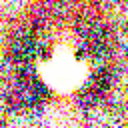

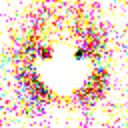

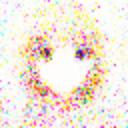

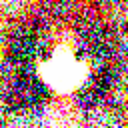

In [29]:
p = transforms.Compose([transforms.Resize((128,128))])
# Generate a random latent vector
latent_vector = torch.randn((17,latent_dim), device=device)

# print(latent_dim)
with torch.no_grad():
    generated_img = generator(latent_vector)

# Convert the generated image tensor to a PIL image
generated_img = generated_img.squeeze(0).cpu()
for i in range(0,16,4):
  generatd_img = transforms.ToPILImage()(generated_img[i])
  img=p(generatd_img)
  img.show()